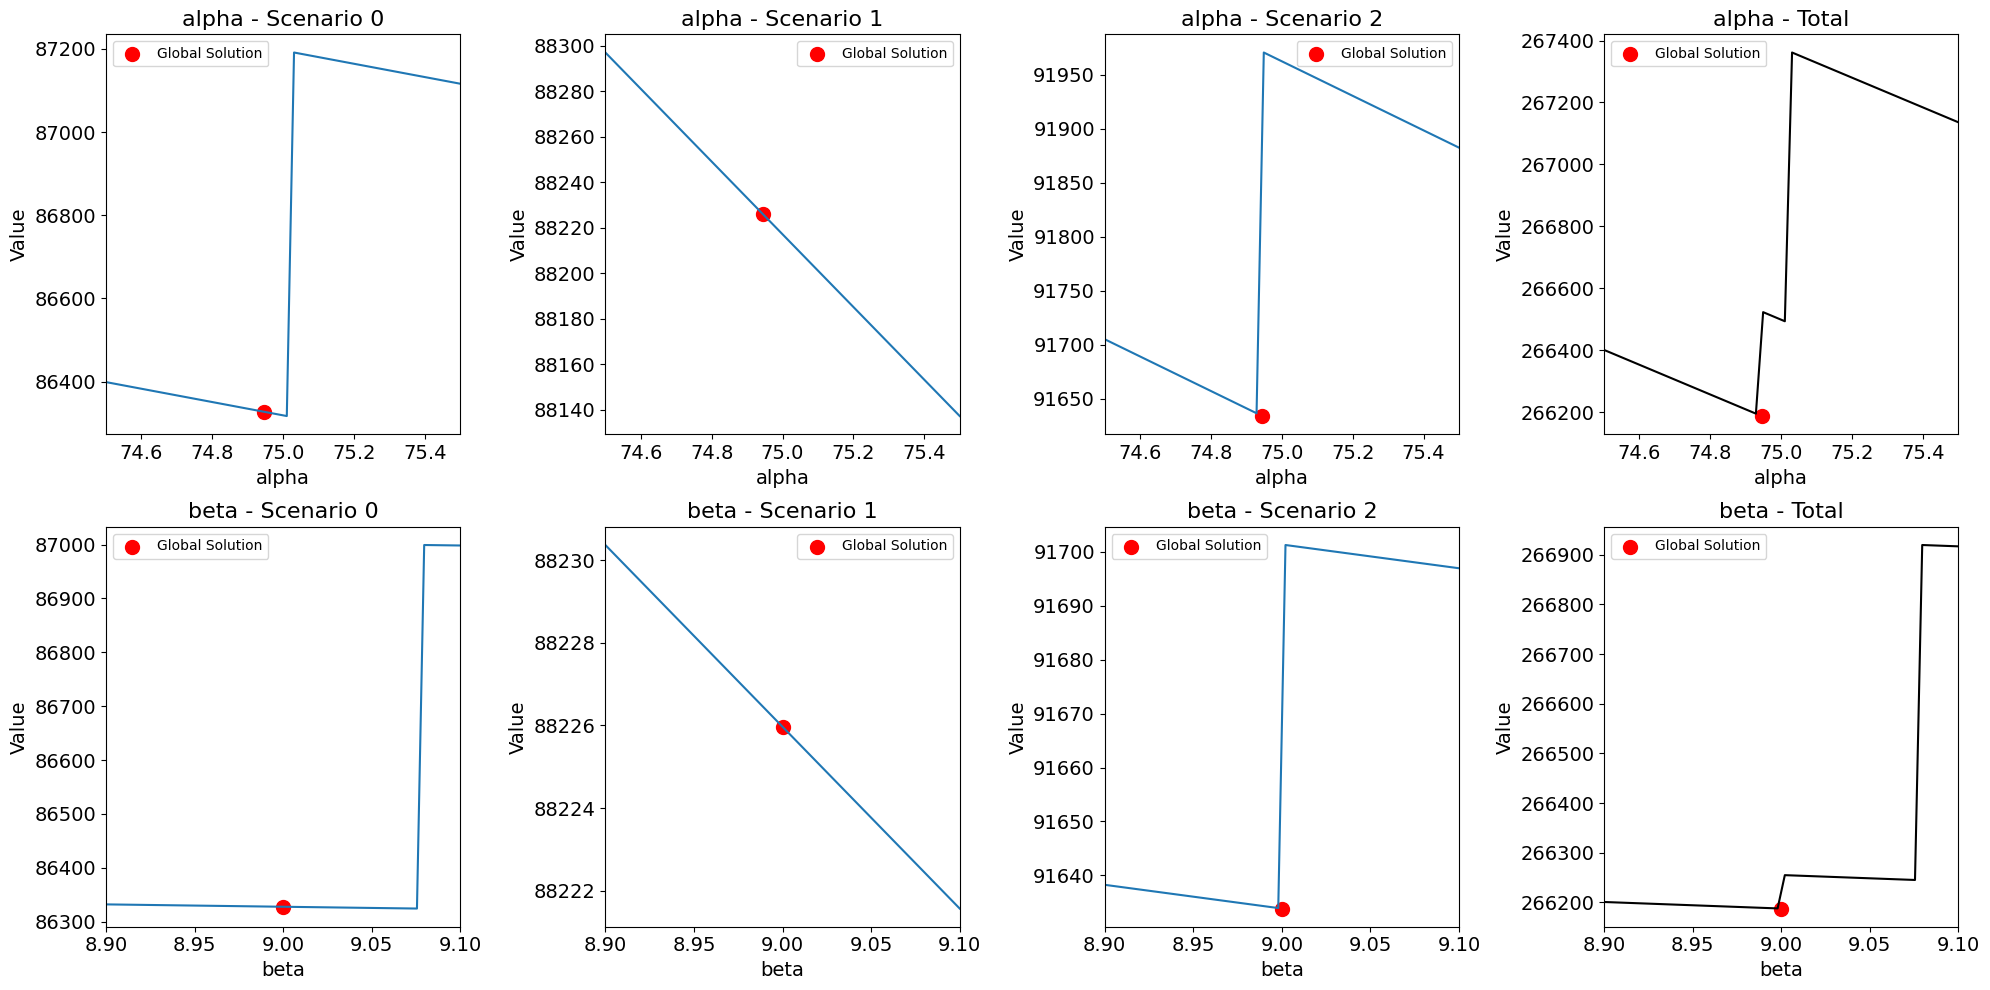

({'alpha': {0: array([86398.87164732, 86395.6063412 , 86392.34103508, 86389.07572896,
          86385.81042283, 86382.54511671, 86379.27981059, 86376.01450447,
          86372.74919834, 86369.48389222, 86366.2185861 , 86362.95327998,
          86359.68797386, 86356.42266773, 86353.15736161, 86349.89205549,
          86346.62674937, 86343.36144324, 86340.09613712, 86336.830831  ,
          86333.56552488, 86330.30021875, 86327.03491263, 86323.76960651,
          86320.50430039, 86317.23899426, 87191.47368814, 87188.20838202,
          87184.9430759 , 87181.67776977, 87178.41246365, 87175.14715753,
          87171.88185141, 87168.61654528, 87165.35123916, 87162.08593304,
          87158.82062692, 87155.55532079, 87152.29001467, 87149.02470855,
          87145.75940243, 87142.4940963 , 87139.22879018, 87135.96348406,
          87132.69817794, 87129.43287181, 87126.16756569, 87122.90225957,
          87119.63695345, 87116.37164732]),
   1: array([88297.12447178, 88293.85916566, 88290.59385

In [1]:
from src.models.cz_model import CaoZavalaModel, CaoZavalaAlgo
from NSPLIB.src.instances.poutil.poutil_SP import const_model
from graphing.value_function.plotting import plotting
# Constants
poutil_obj = 266187.5332404778  # Replace with actual value
poutil_sol = {'alpha': 74.94473247856709, 'beta': 9.000000000000028}  
poutil_y_bound = {'alpha': [0.0, 470], 'beta': [0.0, 470]}  
poutil_y_bound = {'alpha': [74.5, 75.5], 'beta': [8.9, 9.1]}  # Adjusted bounds for better visualization
# Build model
sto_m = const_model()
m = CaoZavalaModel.from_sto_m(sto_m)
m.build()
y_dimension = {
    'alpha': {}, 'beta': {}
}
plotting(m, 50, y_dimension, poutil_sol, poutil_y_bound,poutil_obj)